## Antigenic Fitness  
### Can we quantify the extent to which antigenic novelty contributes to viral fitness?  

#### We make some simplifying assumptions. Specifically:  
* Antigenic fitness is primarily determined by the population of people that have had exactly 1 infection. Otherwise, we assume they are either entirely naive (unexposed) or entirely immune (post-secondary infection), and so their contributions to antigenic fitness are uniform for all genotypes and thus negligible for our purposes. On average, there is a 4-6 year gap between primary and secondary infections in endemic regions.  
* We assume incidence is approximately constant between seasons.  
* We assume unbiased sampling of genotypes.  
* We assume even mixing of genotypes within a region/country of analysis.

#### Antigenic fitness of genotype _i_ essentially depends on:  
* What genotypes, j1 -> jn have people most likely been exposed to in the last 5-6 years?  
* How long ago where they exposed to genotype j? Cross-protective immunity wanes over a period of 1-3 years.
* How antigenically similar are genotypes _i_ and _j_? 

#### Thus, we parameterize _Ti_ as a simple function of genotype frequencies and titer measurements.  

In [9]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
%matplotlib inline
import seaborn as sns
from pprint import pprint
from itertools import permutations
from math import exp, ceil
from numpy import linspace, nanmax, nanmin
from matplotlib import cm
from itertools import combinations

In [2]:
# Pull pre-computed genotype frequencies
dataset_name = 'SEAsia_stiffness2'
out_path = '../../data/frequencies/regions'
frequency_path = '../../data/frequencies/regions/seAsia_stiffness2_pivots4.csv'
titer_path = '../../data/katzelnick2015/processed/genotypes_dTiters.csv'


In [34]:
genotype_frequencies = pd.read_csv(frequency_path, index_col=0)

# Bin seasons by year
seasons = range(1980, 2017)

# Bin each pivot from augur (row in frequencies data) by which season it falls into. Average frequencies by season.
def bin_seasons(df, seasons=seasons):
    def find_season(date, seasons=seasons):
        if int(date) in seasons:
            return int(date)
        else:
            return np.nan
        
    df['season'] = [find_season(date, seasons) for date in df.index.values]
    df.dropna(how='any', inplace=True)
    df['season'] = df['season'].map(lambda x: int(x))
    df = df.groupby('season').agg('mean')
    return df

# serotype_frequencies = bin_seasons(serotype_frequencies, seasons)
genotype_frequencies = bin_seasons(genotype_frequencies, seasons)

print genotype_frequencies.head()

         DENV1_I  DENV1_II  DENV1_IV   DENV1_V  DENV2_AMERICAN  \
season                                                           
1980    0.328900  0.001375  0.054150  0.242000             0.0   
1981    0.502475  0.000600  0.082750  0.041775             0.0   
1982    0.299225  0.000400  0.049275  0.007900             0.0   
1983    0.109200  0.000300  0.017975  0.002625             0.0   
1984    0.043000  0.000300  0.007075  0.001325             0.0   

        DENV2_ASIANAMERICAN  DENV2_ASIANI  DENV2_ASIANII  DENV2_COSMOPOLITAN  \
season                                                                         
1980               0.132225      0.111525       0.000250             0.00625   
1981               0.060350      0.050800       0.000200             0.00405   
1982               0.151125      0.127475       0.000300             0.00655   
1983               0.278600      0.235375       0.000125             0.00460   
1984               0.261900      0.221250       0.000125 

In [35]:
# Pull pre-computed dTiter values
# for each genotype pair.

genotype_titers = pd.read_csv(titer_path, header=0, names=['gt1', 'gt2', 'dTiter'])

# pivot to multiindex for pairwise indexing
index_vals = [tuple(sorted(i)) for i in zip(genotype_titers['gt1'], genotype_titers['gt2'])]
genotype_titers.index = index_vals
genotype_titers = genotype_titers['dTiter']

# sorted list of all the unique values in the index
genotypes = [g for g in sorted(list(set(zip(*index_vals)[0]))) if 'SYLVATIC' not in g]

print genotype_titers[:5]
print genotypes

(DENV1_I, DENV1_II)               6.941821e-09
(DENV1_I, DENV1_V)                4.298855e-01
(DENV1_I, DENV2_AMERICAN)         1.649116e+00
(DENV1_I, DENV2_ASIANAMERICAN)    1.969383e+00
(DENV1_I, DENV2_ASIANI)           1.975779e+00
Name: dTiter, dtype: float64
['DENV1_I', 'DENV1_II', 'DENV1_IV', 'DENV1_V', 'DENV2_AMERICAN', 'DENV2_ASIANAMERICAN', 'DENV2_ASIANI', 'DENV2_ASIANII', 'DENV2_COSMOPOLITAN', 'DENV3_I', 'DENV3_II', 'DENV3_III', 'DENV3_V', 'DENV4_I', 'DENV4_II']


In [36]:
# ##### Toy demo for sanity checking

# genotypes = ['DENV1_I', 'DENV2_COSMOPOLITAN']
# genotype_titers = genotype_titers[[g for g in combinations(genotypes, 2)]]
# genotype_frequencies = genotype_frequencies[genotypes]
# seasons = seasons[:10]
# genotype_frequencies = genotype_frequencies.loc[seasons, :]

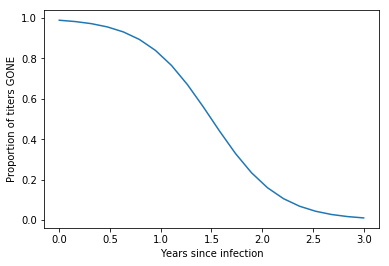

In [37]:
#### Model the waning of cross-protective immunity
def get_decay(s, homotypic):
    ## TO DO fix for homologous/heterologous.
    ''' 
    model immunity as waning according to a 
    sigmoid-y function dependent on s, the number of 
    seasons in the past that the primary infection 
    occurred'''
    if homotypic:
        g_s = 1.0
    else:
        g_s = 1./(1.+exp(3.*(s-1.5)))
    return g_s

plt.plot([x for x in linspace(0,3,num=20)], [get_decay(x, homotypic=False) for x in linspace(0,3,num=20)])
plt.xlabel('Years since infection')
plt.ylabel('Proportion of titers GONE')

In [49]:
#### Frequencies of genotype j
def get_frequency(j, season, genotype_frequencies=genotype_frequencies):
    ''' return the frequency of genotype j in a given season '''
    return genotype_frequencies[j][season]
        
#### Titers for virus i, serum j
def get_dTiter(i,j):
    ''' return dTiter between genotypes i and j'''
    sort_gt = tuple(sorted([i,j]))
    if i == j:
        return 0.
    else:
        return genotype_titers[sort_gt]
    
#### Calculate cumulative exposure to genotype i at the START of each season we have data for
def calc_population_exposure(i, seasons_back, seasons):
    ''' Calculate population exposure at the start of each season we have data for '''
    i_serotype = i.split('_')[0]
    seasons_of_interest = seasons[seasons_back:]
    population_exposure = []
        
    for start in seasons_of_interest:
        past_seasons = [start - s for s in range(1, seasons_back+1)]
        cumulative_exposure = 0.
        
        for n, past_season in enumerate(past_seasons, start=1): # for each season in the past
            for j in genotypes: # for each genotype
                j_serotype = j.split('_')[0]
                homotypic = i_serotype==j_serotype # decay = 1 if homotypic (no waning)
                                                   # 0<decay<1 if heterotypic, dependent on n: how many years in the past
                decay = get_decay(n, homotypic)
                dTiter_ij = get_dTiter(i, j) # 0. if i==j; smaller values indicate greater cross-protection         
                j_frequency = get_frequency(j, past_season) # frequency of j in this previous season
                exposure = (decay * dTiter_ij) * j_frequency
                cumulative_exposure += exposure
                
        population_exposure.append(cumulative_exposure)
    
    return pd.Series(population_exposure, index=seasons_of_interest)

In [50]:
valid_genotypes = [g for g in genotypes if genotype_frequencies[g].max() >= 0.05]
population_exposure = {g: calc_population_exposure(g,3,seasons) for g in valid_genotypes}

population_exposure_df = pd.DataFrame(population_exposure)
min_val = population_exposure_df.values.min()
max_val = population_exposure_df.values.max()
mean_val = population_exposure_df.values.mean()

In [57]:
#### Plot

def plot_exposure_frequencies(i, ax, population_exposure=population_exposure, 
                             genotype_frequencies = genotype_frequencies, **kwargs):
    
    seasons_of_interest = population_exposure[i].index.values
    y = genotype_frequencies[i][seasons_of_interest]
    x = population_exposure[i]
    
    sns.regplot(x,y, ax=ax)
    ax.set_title(i)
    ax.set_ylim(bottom=0.)
    ax.set_xlabel('dTiter(population sera, virus i)')
    ax.set_ylabel('Frequency of virus i')
    
    
def plot_exposure_delta_frequencies(i, ax, population_exposure=population_exposure, 
                             genotype_frequencies = genotype_frequencies, 
                             seasons_forward=3, 
                             **kwargs):
    
    valid_seasons = population_exposure[i].index.tolist() # all available seasons
    delta_seasons = zip(valid_seasons[seasons_forward:], valid_seasons) # [(S + N season, S season)]
    delta_f = [genotype_frequencies[i][s2] - genotype_frequencies[i][s1] for (s2, s1) in delta_seasons]
    
    pop_exp_i = population_exposure[i][valid_seasons[:-1*seasons_forward]]
    
    sns.regplot(pop_exp_i,pd.Series(delta_f), ax=ax)
    
    ax.set_title(i)
    ax.set_xlabel('dTiter(population sera, virus i)')
    ax.set_ylabel('%d-yr change in frequency'%seasons_forward)

    
def plot_time_frequencies_exposure(i, ax, population_exposure=population_exposure, 
                                   genotype_frequencies = genotype_frequencies, 
                                   min_val=min_val, max_val=max_val, **kwargs):
    
    time = genotype_frequencies[i].index.tolist()
    frequencies = genotype_frequencies[i].tolist()
    
    exposure = population_exposure[i].tolist()
    exposure = [x / max_val for x in exposure] # Norm so everything is between 0 and 1 for the cmap
    
    
    c = [cm.autumn_r(e) for e in exposure]
    ax.plot(time, frequencies, '-', c='gray')
    ax.scatter(time,frequencies,c=c, zorder=5, s=20)
    
    ax.set_title(i)
    ax.set_xlabel('Season')
    ax.set_ylabel('Genotype Frequency')
#     ax.set_ylim(0, 0.5)
    
#     if 'colorbar' in kwargs and kwargs['colorbar'] == True:
#         divider = make_axes_locatable(ax)
#         cax = divider.append_axes('right', size='5%', pad=0.05)

#         im = ax.imshow(c)#, cmap='autumn_r')

#         plt.colorbar(im, cax=cax, orientation='vertical')

In [52]:
def plot_all_genotypes(plot_fn, population_exposure, genotype_frequencies = genotype_frequencies, 
                       save=False, plot_name=None, **kwargs):
    sns.set(style='whitegrid', font_scale=1.1, palette='pastel')
    n_genotypes = len(population_exposure.keys())
    ncols = 4
    nrows = int(ceil(n_genotypes/ncols))
    
    sns.set_style('whitegrid')
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, squeeze=True, figsize=(12,8), sharey=True, sharex=True)
    
    for genotype, ax in zip(sorted(population_exposure.keys()), axes.flatten()):
        plot_fn(genotype, ax, population_exposure=population_exposure, 
                genotype_frequencies = genotype_frequencies, **kwargs)
        
    if 'title' in kwargs:
        plt.suptitle(kwargs['title'], va='bottom', size=12)

    plt.tight_layout()
    
    if save:
        plt.savefig(out_path+'/'+dataset_name+plot_name+'.png')
        
    if 'cbar' in kwargs:
        cax = fig.add_axes([1.0, 0.1, 0.02, 0.9], frame_on=False)
        cb = mpl.colorbar.ColorbarBase(cax,cmap='autumn_r',
                                       norm=mpl.colors.Normalize(vmin=min_val,vmax=max_val),orientation='vertical',alpha=1.0,drawedges=False)
        

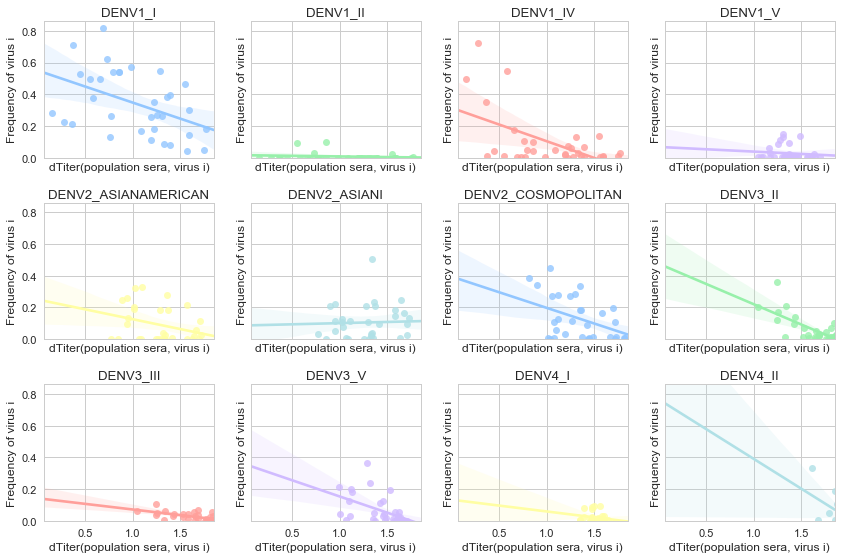

In [53]:
plot_all_genotypes(plot_exposure_frequencies, population_exposure)

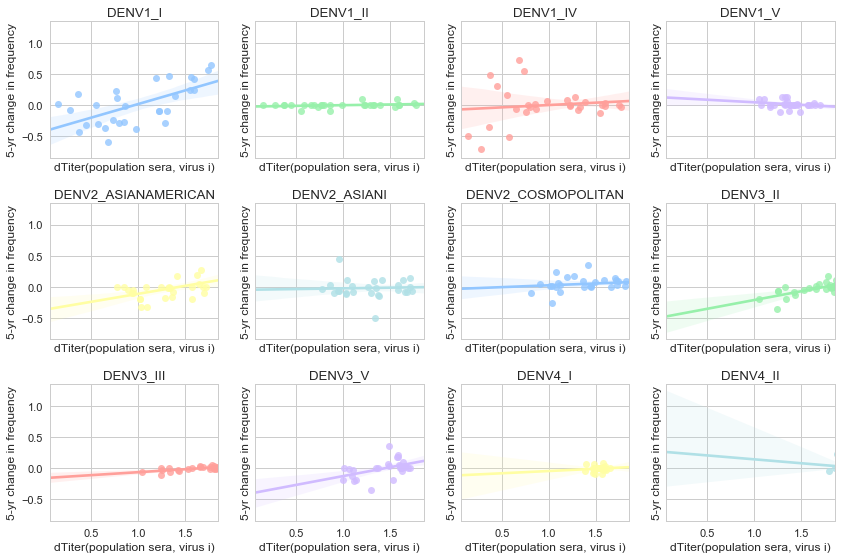

In [58]:
plot_all_genotypes(plot_exposure_delta_frequencies, population_exposure, seasons_forward=5)

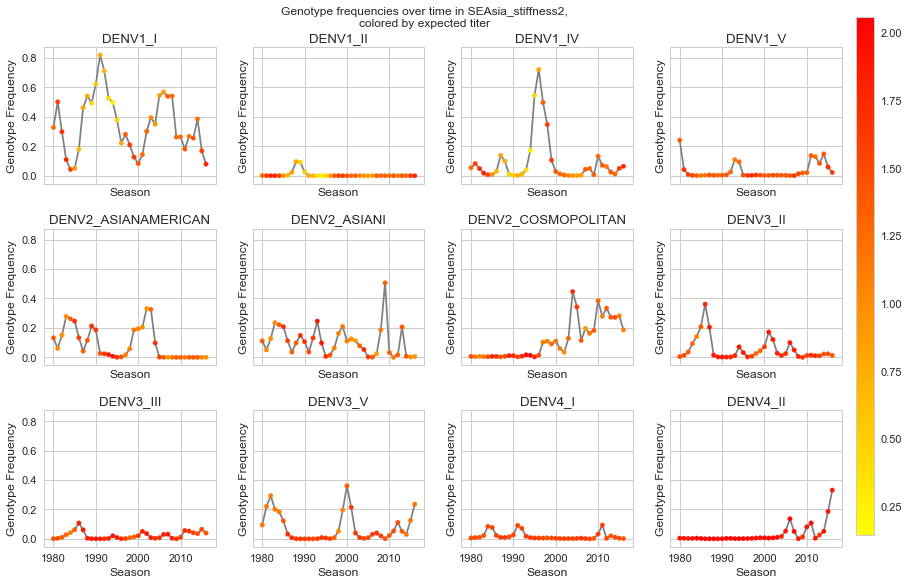

In [54]:
plot_all_genotypes(plot_time_frequencies_exposure, population_exposure, 
                   title='Genotype frequencies over time in %s,\ncolored by expected titer'%dataset_name, 
                   cbar=True)

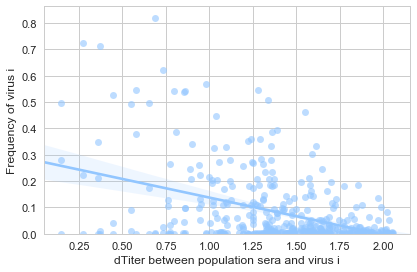

In [90]:
def plot_pooled_exposure_frequencies(population_exposure, frequencies = genotype_frequencies, 
                       save=False, plot_name=None):
    sns.set(style='whitegrid', font_scale=1.2, palette='pastel')
    fig, ax = plt.subplots()
    
    seasons_of_interest = population_exposure.values()[0].index.values
    genotypes = population_exposure.keys()
    
    pooled_frequencies = []
    pooled_exposure = []
    
    for genotype in genotypes:
        pooled_exposure += population_exposure[genotype][seasons_of_interest].tolist()
        pooled_frequencies += frequencies[genotype][seasons_of_interest].tolist()
    
    ax = sns.regplot(pd.Series(pooled_exposure), pd.Series(pooled_frequencies), scatter_kws={'alpha': 0.6})
    ax.set_xlabel('dTiter between population sera and virus i')
    ax.set_ylabel('Frequency of virus i')
    ax.set_ylim(bottom=0)
        
    plt.tight_layout()
    
    if save:
        plt.savefig(out_path+'/'+dataset_name+plot_name+'.png')

plot_pooled_exposure_frequencies(population_exposure)

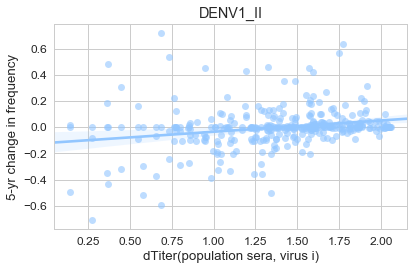

In [104]:
def plot_pooled_exposure_delta_frequencies(population_exposure, frequencies, years_forward=3, 
                                       save=False, plot_name=None):
    
    sns.set(style='whitegrid', font_scale=1.2, palette='pastel')
    fig, ax = plt.subplots()
    
    valid_seasons = population_exposure.values()[0].index.tolist() # all available seasons
    delta_seasons = zip(valid_seasons[years_forward:], valid_seasons) # [(S + N season, S season)]
    
    def delta_f(i):
        return [frequencies[i][s2] - genotype_frequencies[i][s1] for (s2, s1) in delta_seasons]
    
    def pop_exp(i):
        return population_exposure[i][valid_seasons[:-1*years_forward]].tolist()
    
    pooled_exposure = []
    pooled_delta_f = []
    
    for i in population_exposure.keys():
        pooled_exposure += pop_exp(i)
        pooled_delta_f += delta_f(i)
        
    
    sns.regplot(pd.Series(pooled_exposure),pd.Series(pooled_delta_f), ax=ax, scatter_kws={'alpha': 0.6})
    
    ax.set_title(i)
    ax.set_xlabel('dTiter(population sera, virus i)')
    ax.set_ylabel('%d-yr change in frequency'%years_forward)
        
    plt.tight_layout()
    
    if save:
        plt.savefig(out_path+'/'+dataset_name+plot_name+'.png')

plot_pooled_exposure_delta_frequencies(population_exposure, genotype_frequencies, years_forward=5)